<a href="https://colab.research.google.com/github/Ha-minss/Personal-Projects/blob/main/House_prices_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EDA → 결측치 처리 → 상관분석/시각화

다중공선성(VIF) 확인 + 랜덤포레스트 변수 중요도(선택적)

파생 변수 추가 → 중복 피처 제거 + 이상치 후보 저장

로그 변환 + 원-핫 인코딩

LassoCV → 변수 선택

XGBoost → CV로 최적 모델 선택

앙상블(Lasso + XGBoost) → 최종 제출

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, KFold
#from xgboost import XGBRegressor
import os
#Joblib이 TMPDIR로 사용할 경로를 강제로 ASCII-only로 지정
os.environ['JOBLIB_TEMP_FOLDER'] = r"C:\temp"
from sklearn.metrics import mean_squared_error

In [8]:
from google.colab import files
files.upload()  # 여기서 kaggle.json 파일 선택

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ehdgk0725","key":"efa68270d8926dcaeb86446184e814ea"}'}

In [ ]:
# 1) ~/.kaggle 디렉토리 생성
!mkdir -p ~/.kaggle

# 2) 업로드된 kaggle.json을 이동
!cp kaggle.json ~/.kaggle/

# 3) 권한 설정 (안전하게 읽기 전용)
!chmod 600 ~/.kaggle/kaggle.json

# 4) Kaggle API 클라이언트 설치
!pip install -q kaggle

In [ ]:
# Ames Housing 데이터 다운로드
!kaggle competitions download -c house-prices-advanced-regression-techniques

# 압축 해제
!unzip -q house-prices-advanced-regression-techniques.zip -d data

In [26]:
import os
print("data 폴더 내용:", os.listdir("data"))

data 폴더 내용: ['train.csv', 'sample_submission.csv', 'test.csv', 'data_description.txt']


In [27]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv("data/test.csv")

## EDA

In [28]:
display(train_data.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [29]:
train_data = train_data.drop("Id", axis = 1)
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

None

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


<Axes: xlabel='SalePrice', ylabel='Count'>

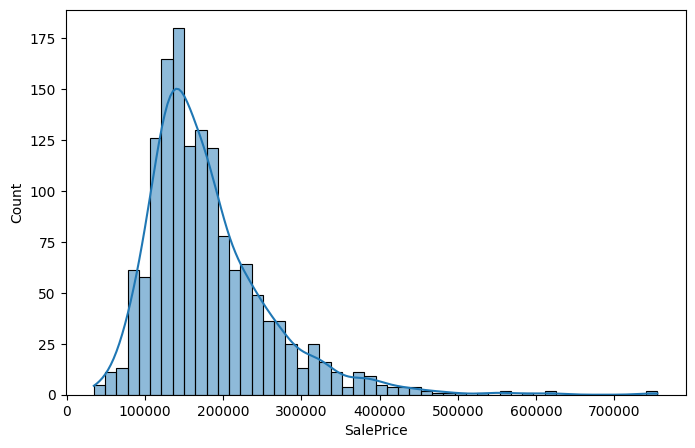

In [30]:
display(train_data["SalePrice"].describe())
plt.figure(figsize=(8, 5))
sns.histplot(train_data['SalePrice'], bins=50, kde=True)

In [31]:
print(list(set(train_data.dtypes.tolist())))

[dtype('float64'), dtype('int64'), dtype('O')]


In [32]:
train_data_num = train_data.select_dtypes(include = ["int64", "float64"])
train_data_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


<Figure size 2000x2000 with 0 Axes>

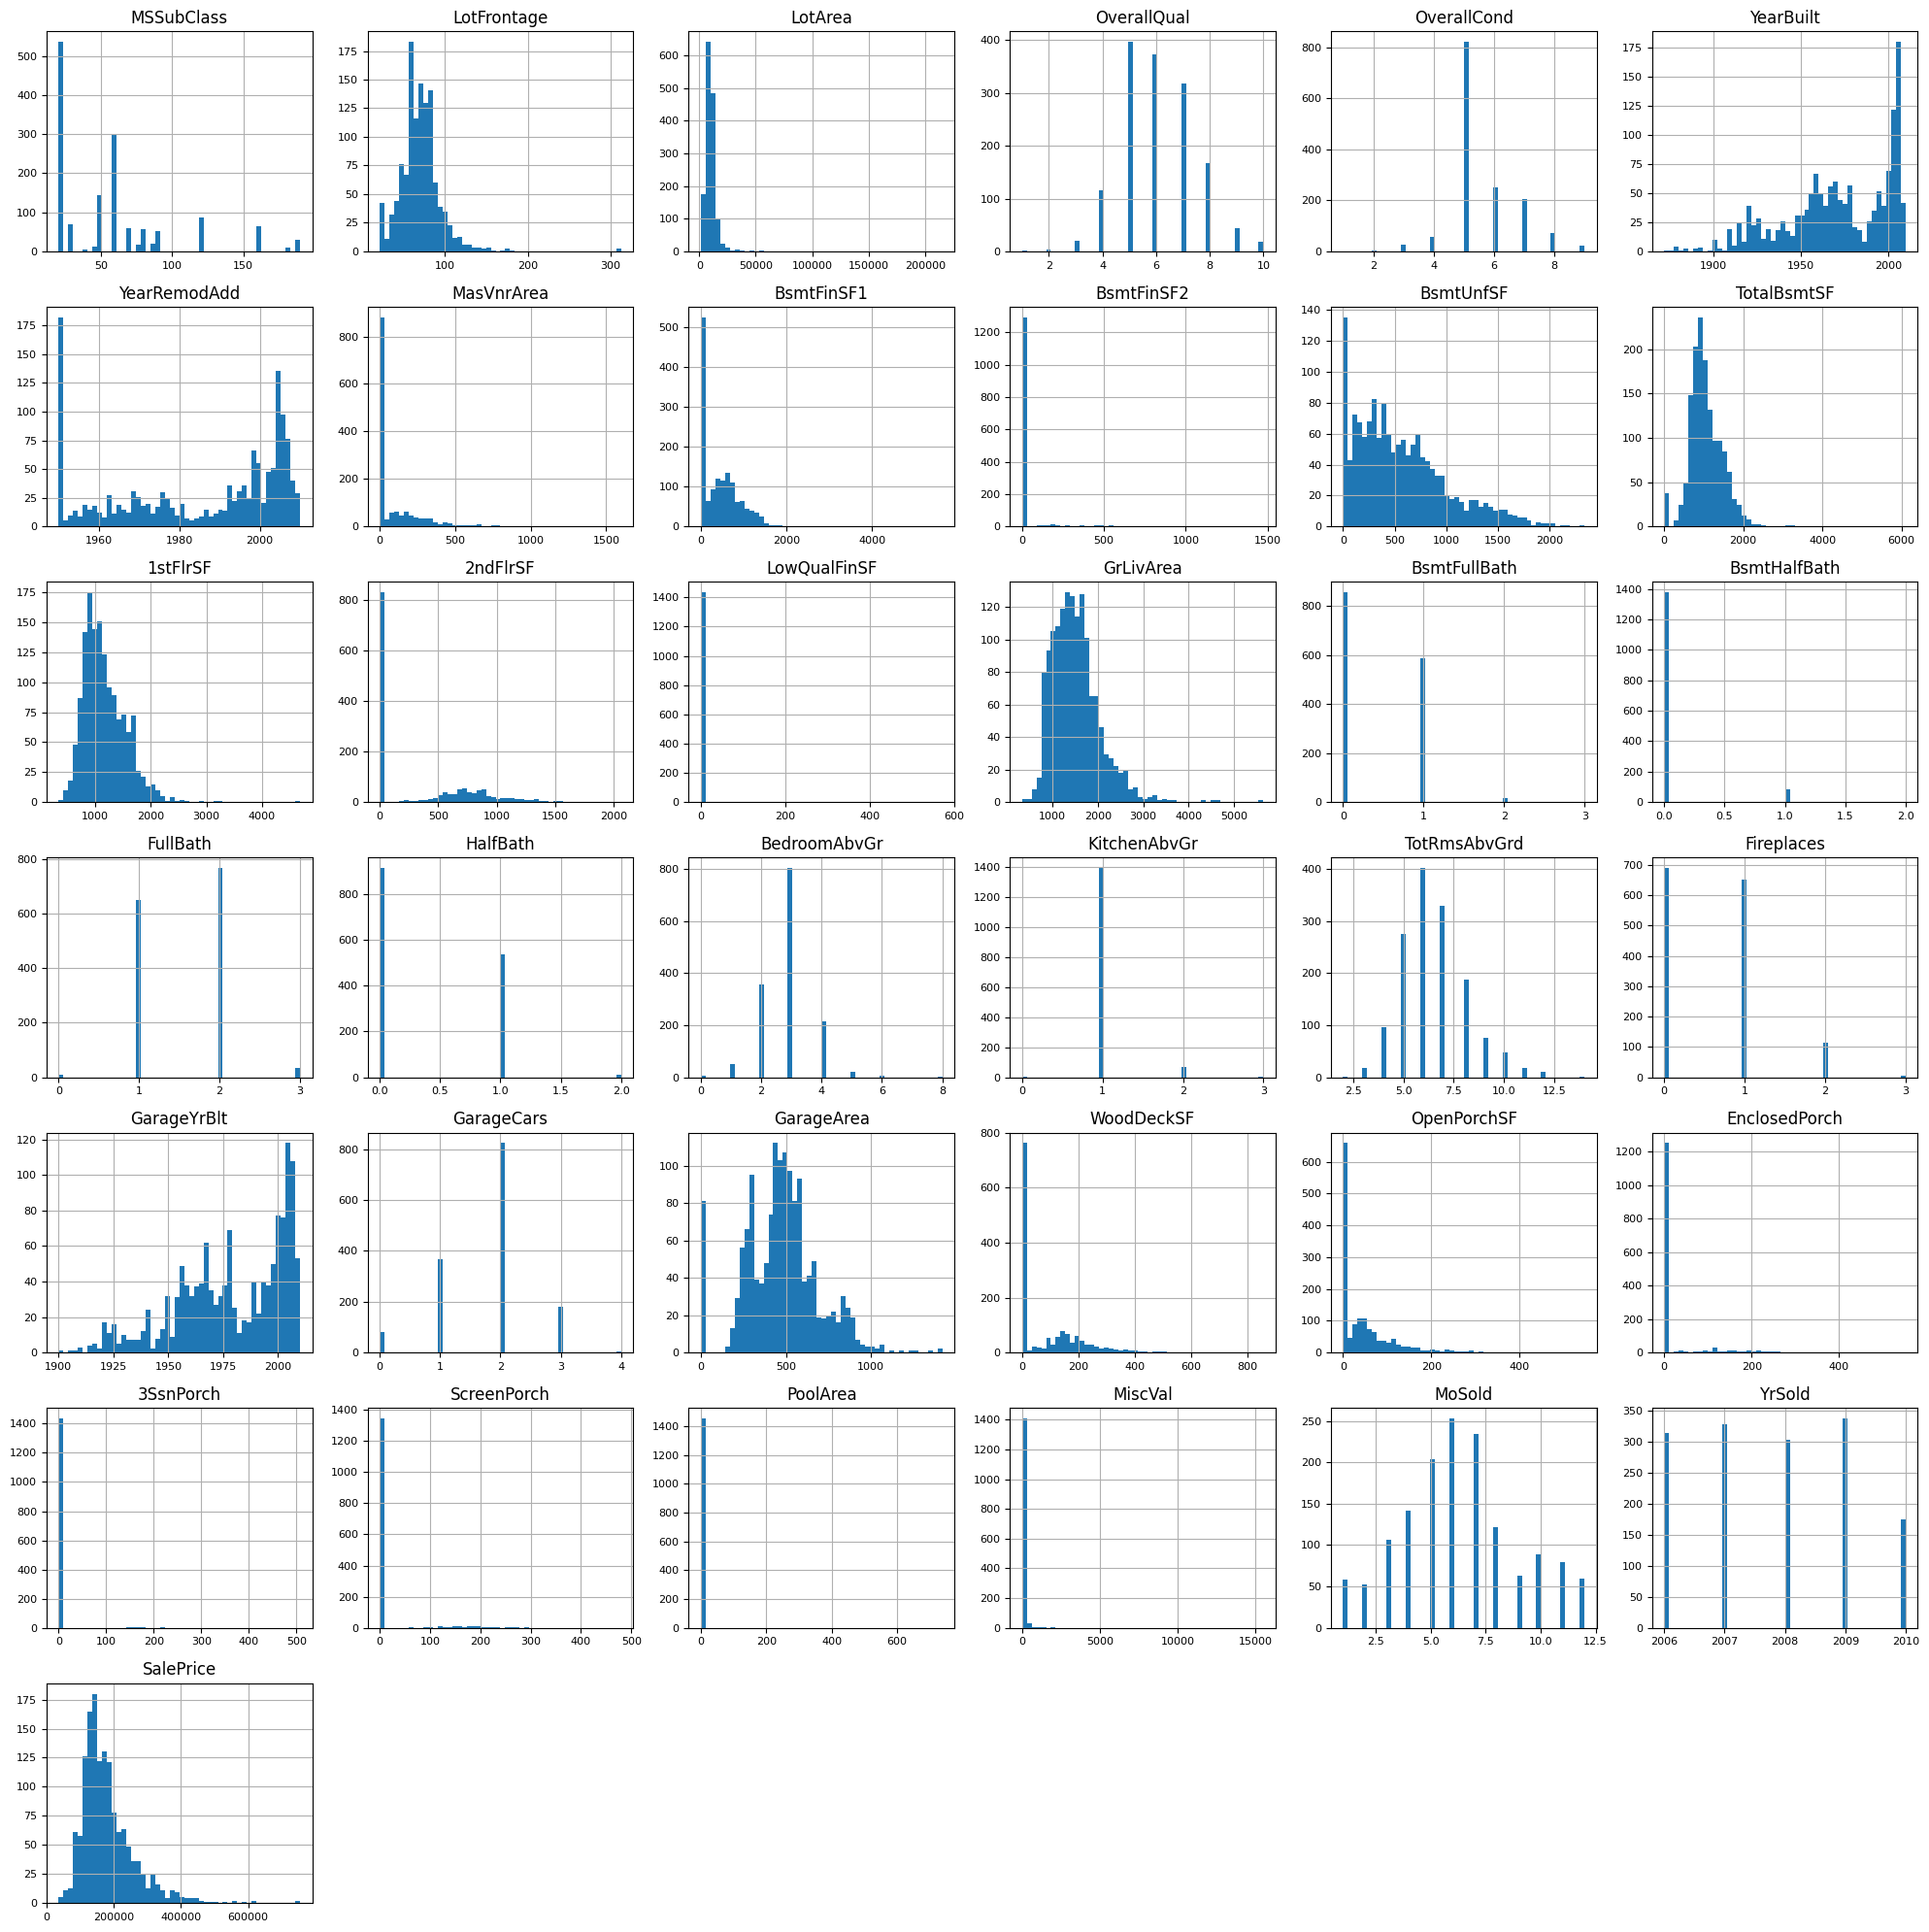

In [33]:
plt.figure(figsize =(20,20))
train_data_num.hist(bins = 50, figsize =(20,20), xlabelsize= 8, ylabelsize= 8)
plt.tight_layout()
plt.show()

## 결측치 처리

In [34]:
missing = train_data.isna().sum()
missing_percent = (missing/len(train_data)) * 100
missing_df = pd.DataFrame({
    "column": missing.index,
    "missing count": missing.values,
    "missing percent": missing_percent.values
}).sort_values(by = "missing percent", ascending= False)

display(missing_df.head(30))

,column,missing count,missing percent
71,PoolQC,1453,99.520548
73,MiscFeature,1406,96.301370
5,Alley,1369,93.767123
72,Fence,1179,80.753425
24,MasVnrType,872,59.726027
56,FireplaceQu,690,47.260274
2,LotFrontage,259,17.739726
62,GarageQual,81,5.547945
57,GarageType,81,5.547945
59,GarageFinish,81,5.547945


In [35]:
# 숫자형 컬럼 중 결측이 있는 것만 따로 추출
num_cols_with_na = [col for col in train_data.select_dtypes(include=['int64','float64']).columns
                    if train_data[col].isna().sum() > 0]
num_cols_with_na, len(num_cols_with_na)

(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], 3)

In [36]:
# ① train_data에서 숫자형 결측을 각각 평균으로 채우기
for col in num_cols_with_na:
    mean_val = train_data[col].mean()
    train_data[col].fillna(mean_val, inplace=True)

# ② test_data에도 동일하게 동일한 평균값으로 채우기 (train 평균 사용)
for col in num_cols_with_na:
    mean_val = train_data[col].mean()
    test_data[col].fillna(mean_val, inplace=True)

# 채워졌는지 확인
train_data[num_cols_with_na].isna().sum()

<ipython-input-36-f71b908bf344>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(mean_val, inplace=True)
<ipython-input-36-f71b908bf344>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,0
LotFrontage,0
MasVnrArea,0
GarageYrBlt,0


In [37]:
# 1) object 타입(범주형) 컬럼 중 결측치가 있는 컬럼만 뽑기
cat_cols_with_na = [
    col for col in train_data.select_dtypes(include='object').columns
    if train_data[col].isna().sum() > 0
]
cat_cols_with_na

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [38]:
cols_fill_none = ['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']
for col in cols_fill_none:
    train_data[col].fillna('None', inplace=True)
    test_data[col].fillna('None', inplace=True)

# 채워졌는지 확인
train_data[cols_fill_none].isna().sum()

<ipython-input-38-022b605fcea1>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna('None', inplace=True)
<ipython-input-38-022b605fcea1>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,0
Alley,0
MasVnrType,0
BsmtQual,0
BsmtCond,0
BsmtExposure,0
BsmtFinType1,0
BsmtFinType2,0
FireplaceQu,0
GarageType,0
GarageFinish,0


In [39]:
electrical_mode = train_data['Electrical'].mode()[0]
train_data['Electrical'].fillna(electrical_mode, inplace=True)
test_data['Electrical'].fillna(electrical_mode, inplace=True)

<ipython-input-39-f74260563a4c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Electrical'].fillna(electrical_mode, inplace=True)
<ipython-input-39-f74260563a4c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

## 상관분석/시각화

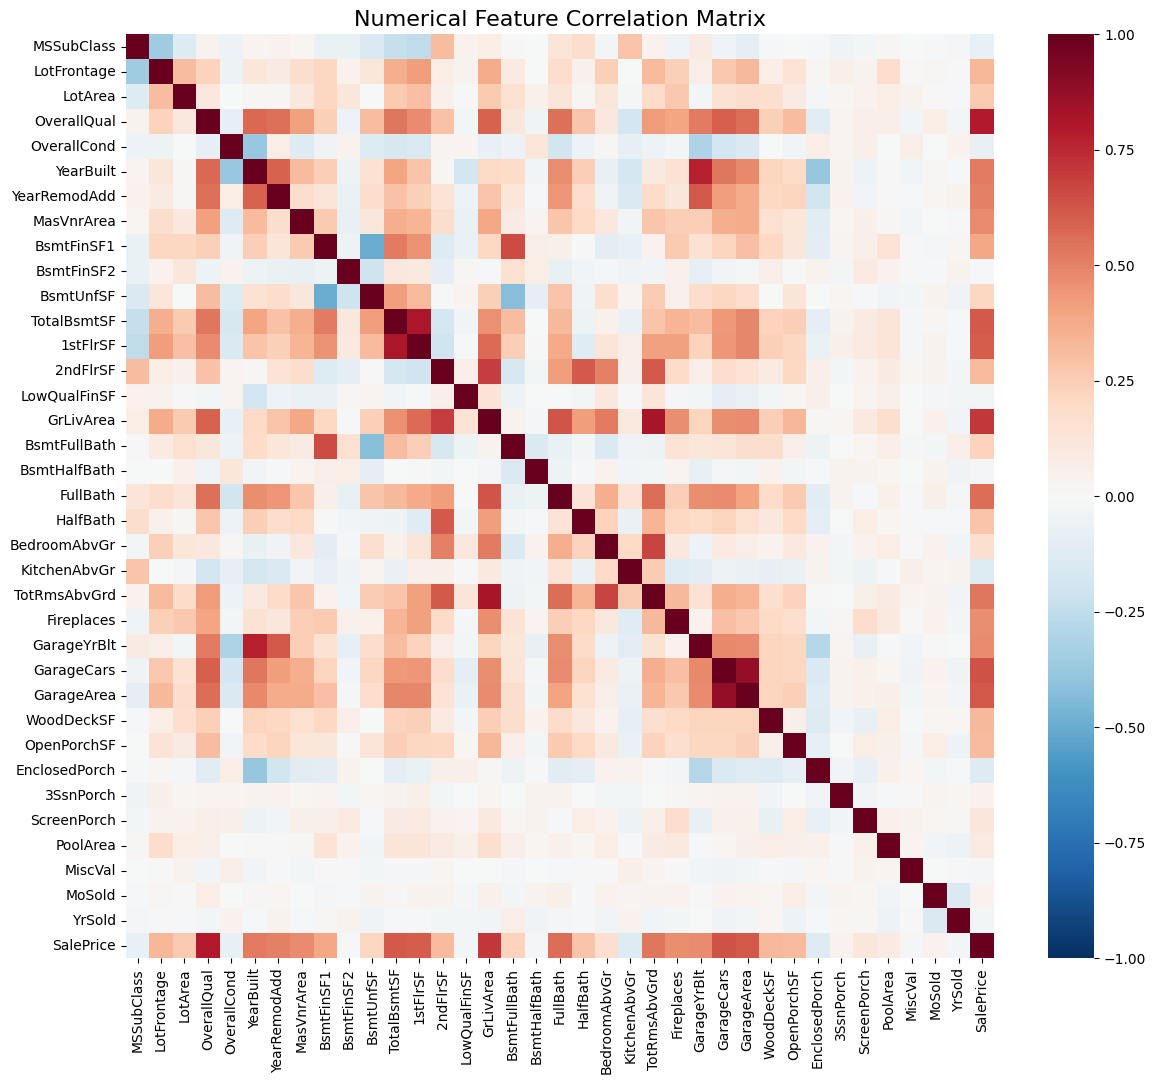

In [41]:
# 1) 숫자형 컬럼만 골라서 상관행렬 계산
#    SalePrice도 포함해서 타깃과의 관계도 함께 살펴보겠습니다.
num_feats = train_data.select_dtypes(include=['int64','float64'])

# 2) 상관행렬
corr_matrix = num_feats.corr()

# 3) 히트맵으로 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title("Numerical Feature Correlation Matrix", fontsize=16)
plt.show()

In [42]:
# ② SalePrice와의 상관계수만 절댓값 기준으로 정렬
corr_with_target = num_feats.corr()['SalePrice'].abs().sort_values(ascending=False)

# ③ 상위 30개 상관변수 출력 (SalePrice 제외하고)
print("SalePrice와 절댓값 상관계수 상위 30개 변수:")
print(corr_with_target.iloc[1:30])  # 0번째가 항상 SalePrice 본인이기 때문에 1:11로 자름

SalePrice와 절댓값 상관계수 상위 30개 변수:
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.475241
GarageYrBlt      0.470177
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.334901
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
Name: SalePrice, dtype: float64


In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ① 숫자형 변수만 뽑아서 타깃(SalePrice) 제외
X = train_data.select_dtypes(include=['int64','float64']).drop(columns=['SalePrice'])

# ② VIF 계산을 위해 상수항(constant) 추가
X_const = add_constant(X)

# ③ 변수별 VIF 계산
vif_data = pd.DataFrame({
    'feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})

# ④ 상수항을 제외하고 VIF 내림차순 정렬
vif_data = vif_data[vif_data['feature'] != 'const'].sort_values(by='VIF', ascending=False).reset_index(drop=True)
vif_data.head(30)

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,BsmtFinSF1,inf
1,BsmtFinSF2,inf
2,BsmtUnfSF,inf
3,TotalBsmtSF,inf
4,GrLivArea,inf
5,LowQualFinSF,inf
6,2ndFlrSF,inf
7,1stFlrSF,inf
8,GarageCars,5.576859
9,GarageArea,5.468439


In [44]:
# 1) GROUND AREA: GrLivArea만 남기고 1stFlrSF, 2ndFlrSF 제거
for col in ['1stFlrSF', '2ndFlrSF']:
    if col in train_data.columns: train_data.drop(columns=[col], inplace=True)
    if col in test_data.columns:  test_data.drop(columns=[col], inplace=True)

# 2) BASEMENT AREA: TotalBsmtSF만 남기고 BsmtFinSF1, BsmtFinSF2, BsmtUnfSF 제거
for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']:
    if col in train_data.columns: train_data.drop(columns=[col], inplace=True)
    if col in test_data.columns:  test_data.drop(columns=[col], inplace=True)

# 3) LOW QUALITY BASEMENT: LowQualFinSF 제거
if 'LowQualFinSF' in train_data.columns: train_data.drop(columns=['LowQualFinSF'], inplace=True)
if 'LowQualFinSF' in test_data.columns:  test_data.drop(columns=['LowQualFinSF'], inplace=True)

# 4) GARAGE: GarageArea만 남기고 GarageCars 제거 (또는 반대로)
for col in ['GarageCars']:
    if col in train_data.columns: train_data.drop(columns=[col], inplace=True)
    if col in test_data.columns:  test_data.drop(columns=[col], inplace=True)

# 5) BATH: 파생 변수 TotalBaths 생성 후 원본 컬럼(FULL/HALF/BsmtFull/BsmtHalf) 삭제
train_data['TotalBaths'] = (
    train_data['FullBath'] + 0.5 * train_data['HalfBath'] +
    train_data['BsmtFullBath'] + 0.5 * train_data['BsmtHalfBath']
)
test_data['TotalBaths'] = (
    test_data['FullBath'] + 0.5 * test_data['HalfBath'] +
    test_data['BsmtFullBath'] + 0.5 * test_data['BsmtHalfBath']
)
for col in ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']:
    if col in train_data.columns: train_data.drop(columns=[col], inplace=True)
    if col in test_data.columns:  test_data.drop(columns=[col], inplace=True)

# 6) QUALITY: OverallQual만 사용하고, 나머지 등급형 컬럼(ExterQual 등) 제거
quality_to_drop = [
    'ExterQual', 'ExterCond', 'KitchenQual',
    'BsmtQual', 'BsmtCond', 'FireplaceQu',
    'GarageQual', 'GarageCond'
]
for col in quality_to_drop:
    if col in train_data.columns: train_data.drop(columns=[col], inplace=True)
    if col in test_data.columns:  test_data.drop(columns=[col], inplace=True)

# 7) PORCH: 파생 변수 TotalPorchSF 생성 후 네 개 컬럼 제거
train_data['TotalPorchSF'] = (
    train_data['WoodDeckSF'] +
    train_data['OpenPorchSF'] +
    train_data['EnclosedPorch'] +
    train_data['ScreenPorch']
)
test_data['TotalPorchSF'] = (
    test_data['WoodDeckSF'] +
    test_data['OpenPorchSF'] +
    test_data['EnclosedPorch'] +
    test_data['ScreenPorch']
)
for col in ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']:
    if col in train_data.columns: train_data.drop(columns=[col], inplace=True)
    if col in test_data.columns:  test_data.drop(columns=[col], inplace=True)

# 8) MasVnr (석재 마감): MasVnrArea만 다루고, MasVnrType은 필요하면 Label Encoding 후 남겨두거나,
#    정보가 크게 덜 중요하면 둘 다 제거할 수 있음
#    예시: 일단 MasVnrArea만 남겨두기로 하고, MasVnrType 을 제거
if 'MasVnrType' in train_data.columns: train_data.drop(columns=['MasVnrType'], inplace=True)
if 'MasVnrType' in test_data.columns:  test_data.drop(columns=['MasVnrType'], inplace=True)

# 9) 판매 월/연도: YrSold만 남기고 MoSold 제거 (또는 반대로)
if 'MoSold' in train_data.columns: train_data.drop(columns=['MoSold'], inplace=True)
if 'MoSold' in test_data.columns:  test_data.drop(columns=['MoSold'], inplace=True)

# 10) MSSubClass는 사실 범주형(카테고리 코드)이라 OHE 대상으로 두고,
#     BldgType, HouseStyle 중 하나만 남겨도 무방. 예시: BldgType 제거
if 'BldgType' in train_data.columns: train_data.drop(columns=['BldgType'], inplace=True)
if 'BldgType' in test_data.columns:  test_data.drop(columns=['BldgType'], inplace=True)

In [45]:
# 1) 현재 남아 있는 칼럼 확인
print("남아 있는 칼럼들:")
print(train_data.columns.tolist())

# 2) 숫자형 변수만 뽑아서 VIF 계산 준비 (SalePrice 제외)
X = train_data.select_dtypes(include=['int64','float64']).drop(columns=['SalePrice'])

# 3) 상수항 추가
X_const = add_constant(X)

# 4) 변수별 VIF 계산
vif_data = pd.DataFrame({
    'feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})

# 5) 상수항 제외하고 VIF 내림차순 정렬
vif_data = vif_data[vif_data['feature'] != 'const'].sort_values('VIF', ascending=False).reset_index(drop=True)
print("\nVIF 결과(상위 40개까지):")
print(vif_data.head(40))

남아 있는 칼럼들:
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageArea', 'PavedDrive', '3SsnPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'TotalBaths', 'TotalPorchSF']

VIF 결과(상위 40개까지):
         feature       VIF
0      GrLivArea  5.826789
1   TotRmsAbvGrd  4.801477
2      YearBuilt  4.102642
3    GarageYrBlt  3.152070
4    OverallQual  3.038568
5   YearRemodAdd  2.346556
6     TotalBat

## 로그변환 + 원핫인코딩

In [49]:
# 1) train_data에서 수치형 변수들만 골라놓습니다.
num_feats = train_data.select_dtypes(include=['int64','float64']).copy()

# 2) 카테고리처럼 다뤄야 하는 정수형 변수 제외
exclude_list = [
    'MSSubClass', 'KitchenAbvGr', 'BedroomAbvGr', 'TotRmsAbvGrd',
    'HalfBath', 'FullBath', 'BsmtHalfBath', 'BsmtFullBath',
    'GarageCars', 'Fireplaces', 'MiscVal'
]
for col in exclude_list:
    if col in num_feats.columns:
        num_feats.drop(columns=[col], inplace=True)

# 3) 값이 0 이상인 연속형 변수만 남겼는지 확인
cont_feats = [col for col in num_feats.columns if train_data[col].min() >= 0]
print("연속형 + 0 이상 변수들:", cont_feats)

# 4) 왜도 계산
skew_vals = {col: train_data[col].skew() for col in cont_feats}

# 5) 절댓값 왜도 > 0.8인 변수만 필터링 (SalePrice는 제외)
skewed_feats = [col for col, sk in skew_vals.items() if abs(sk) > 0.8 and col != 'SalePrice']
print("절댓값 왜도 > 0.8인 변수들:", skewed_feats)

# 6) 실제 로그 변환 적용
for col in skewed_feats:
    train_data[col] = np.log1p(train_data[col])
    test_data[col]  = np.log1p(test_data[col])

# 7) 변환 후 다시 왜도 확인
for col in skewed_feats:
    print(col, "→ skew(after log):", train_data[col].skew())


연속형 + 0 이상 변수들: ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', '3SsnPorch', 'PoolArea', 'YrSold', 'SalePrice', 'TotalBaths', 'TotalPorchSF']
절댓값 왜도 > 0.8인 변수들: ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', '3SsnPorch', 'PoolArea', 'TotalPorchSF']
LotFrontage → skew(after log): -0.8919767349062553
LotArea → skew(after log): -0.13740448122837784
MasVnrArea → skew(after log): 0.48112012705551577
TotalBsmtSF → skew(after log): -5.1546699835179135
GrLivArea → skew(after log): -0.006140253486287248
3SsnPorch → skew(after log): 7.734974870241933
PoolArea → skew(after log): 14.363102459725052
TotalPorchSF → skew(after log): -1.2890089801585893


In [50]:
# 1) 타깃 SalePrice를 로그 변환해 새 컬럼 생성
train_data['SalePrice_log'] = np.log1p(train_data['SalePrice'])

# 2) 이제 drop 시에 오류가 발생하지 않습니다
cat_cols = train_data.select_dtypes(include='object').columns.tolist()

df_all = pd.concat(
    [ train_data.drop(columns=['SalePrice','SalePrice_log']),
      test_data ],
    axis=0, ignore_index=True
)

df_all = pd.get_dummies(df_all, columns=cat_cols, drop_first=True)

n_train = train_data.shape[0]
X      = df_all.iloc[:n_train, :].copy().reset_index(drop=True)
X_test = df_all.iloc[n_train:, :].copy().reset_index(drop=True)
y      = train_data['SalePrice_log'].copy().reset_index(drop=True)

In [51]:
cat_cols = train_data.select_dtypes(include='object').columns.tolist()

# train+test 합치기
df_all = pd.concat(
    [train_data.drop(columns=['SalePrice','SalePrice_log']), test_data],
    axis=0, ignore_index=True
)
df_all = pd.get_dummies(df_all, columns=cat_cols, drop_first=True)

# train/test로 다시 분리
n_train = train_data.shape[0]
X = df_all.iloc[:n_train, :].copy()
X_test = df_all.iloc[n_train:, :].copy()
y = train_data['SalePrice_log'].copy()

In [52]:
# 1) X, y 준비 (전처리 & 인코딩까지 끝난 상태라 가정)
#    - X_all: train_data에서 SalePrice_log을 제외한 모든 피처(수치형+더미컬럼)
#    - y_all: train_data['SalePrice_log'] (로그 변환된 타깃)
X_all = X.copy()       # 앞서 생성한 X (원핫 인코딩 + 로그변환 완료)
y_all = train_data['SalePrice_log'].copy()
X_all = X_all.drop(columns=['Id'])

# 2) train/validation으로 75% : 25% 비율로 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_all,
    test_size=0.25,    # 검증 데이터 25%
    random_state=42    # 재현성을 위해 시드 고정
)

print("훈련용 데이터 개수:", X_train.shape[0])
print("검증용 데이터 개수:", X_valid.shape[0])

훈련용 데이터 개수: 1095
검증용 데이터 개수: 365


In [53]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

## LassoCV → 변수 선택 + XGBoost → CV로 최적 모델 선택

In [54]:
alphas = np.logspace(-4, -1, 50)  # 50개의 후보

# ② LassoCV 객체 생성 (내부에서 5-fold CV)
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5,               # 5-fold 교차검증으로 최적 alpha 탐색
    max_iter=10000,
    random_state=42,
    n_jobs=-1
)

# ③ 훈련 데이터로 최적 α 찾으면서 학습
lasso_cv.fit(X_train_scaled, y_train)
print("최적 alpha:", lasso_cv.alpha_)

최적 alpha: 0.004498432668969444


In [55]:
# ① 검증 데이터로 예측 수행 (로그 스케일 상태)
pred_lasso_valid = lasso_cv.predict(X_valid_scaled)

# ② RMSE(log) 계산
rmse_log_lasso = np.sqrt(mean_squared_error(y_valid, pred_lasso_valid))
print("Lasso 검증 RMSE(log):", rmse_log_lasso)

Lasso 검증 RMSE(log): 0.1387127065012888


In [56]:
# ① 피처별 회귀계수(로그 스케일 상태)
coef_series = pd.Series(lasso_cv.coef_, index=X_train.columns)
coef_nonzero = coef_series[coef_series != 0].sort_values(key=abs, ascending=False)

print("Lasso에서 선택된(비 0) 피처 개수:", len(coef_nonzero))
print(coef_nonzero.head(30))   # 상위 30개만 출력

Lasso에서 선택된(비 0) 피처 개수: 78
GrLivArea                0.129807
OverallQual              0.085163
YearBuilt                0.059099
LotArea                  0.043401
OverallCond              0.038983
GarageArea               0.035658
TotalBaths               0.028649
PoolQC_Gd               -0.023718
Neighborhood_NridgHt     0.023016
Fireplaces               0.021850
TotalBsmtSF              0.021581
YearRemodAdd             0.020358
Condition2_PosN         -0.020191
Neighborhood_StoneBr     0.018622
Exterior1st_BrkFace      0.016117
KitchenAbvGr            -0.016011
Neighborhood_Crawfor     0.015661
BsmtFinType1_Unf        -0.015573
Foundation_PConc         0.015415
Functional_Typ           0.014576
Condition1_Norm          0.014138
SaleCondition_Partial    0.013689
SaleCondition_Alloca     0.011637
Neighborhood_NoRidge     0.011305
BsmtExposure_Gd          0.010977
HouseStyle_1Story        0.010220
MSSubClass              -0.009836
Functional_Maj2         -0.008754
BsmtExposure_No      

In [64]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split

# 1) XGBRegressor 객체
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# 2) 탐색할 하이퍼파라미터 후보
param_dist = {
    'learning_rate':  [0.01, 0.03, 0.05, 0.1],
    'max_depth':      [3, 4, 5, 6],
    'subsample':      [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'n_estimators':   [200, 400, 600, 800],
    'reg_alpha':      [0, 0.01, 0.1],
    'reg_lambda':     [1, 2, 3]
}

# 3) KFold 설정 (5-Fold CV)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4) RandomizedSearchCV 정의 (20개 조합 무작위 탐색)
rs = RandomizedSearchCV(
    xgb_reg,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=kf,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# 5) 학습 (eval_set과 early_stopping_rounds 제거)
rs.fit(X_train, y_train)

# 6) 결과 확인
print("Best params:", rs.best_params_)
print("Best CV RMSE(log):", -rs.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.7}
Best CV RMSE(log): 0.12440967653348338


In [69]:
# 1) XGBoost 검증 예측값 구하기
# rs.best_estimator_ 는 RandomizedSearchCV에서 탐색된 최적 XGBRegressor 객체입니다.
# X_valid (스케일링 전 원본 피처)로 예측하면 됩니다.
pred_xgb_valid = rs.best_estimator_.predict(X_valid)

# 2) Lasso 검증 예측값은 이미 pred_lasso_valid에 저장되어 있습니다.
#    (y_valid는 로그 변환된 타깃, X_valid_scaled는 스케일된 검증 피처)

# 3) 두 모델의 예측값 출력 예시
print("XGBoost 검증 예측값 예시:", pred_xgb_valid[:5])
print("Lasso   검증 예측값 예시:", pred_lasso_valid[:5])

# 4) 가중치 w를 0.0~1.0 사이에서 변화시키며 최적 RMSE(log) 찾기
def blended_rmse_log(w):
    blend = w * pred_lasso_valid + (1 - w) * pred_xgb_valid
    return np.sqrt(mean_squared_error(y_valid, blend))

weights = np.linspace(0.2, 0.4, 21)  # 0.0, 0.1, 0.2, ..., 1.0
best_w, best_score = None, np.inf
for w in weights:
    score = blended_rmse_log(w)
    print(f"w={w:.1f} → RMSLE(log)={score:.4f}")
    if score < best_score:
        best_w, best_score = w, score

print(f"\n최적 가중치: w={best_w:.2f}, 앙상블 RMSLE(log)={best_score:.4f}")


XGBoost 검증 예측값 예시: [11.877881 12.72238  11.604992 11.892973 12.839808]
Lasso   검증 예측값 예시: [11.9343864  12.68466366 11.56569712 12.00075387 12.61878922]
w=0.2 → RMSLE(log)=0.1237
w=0.2 → RMSLE(log)=0.1236
w=0.2 → RMSLE(log)=0.1236
w=0.2 → RMSLE(log)=0.1236
w=0.2 → RMSLE(log)=0.1236
w=0.2 → RMSLE(log)=0.1236
w=0.3 → RMSLE(log)=0.1236
w=0.3 → RMSLE(log)=0.1236
w=0.3 → RMSLE(log)=0.1236
w=0.3 → RMSLE(log)=0.1236
w=0.3 → RMSLE(log)=0.1236
w=0.3 → RMSLE(log)=0.1236
w=0.3 → RMSLE(log)=0.1237
w=0.3 → RMSLE(log)=0.1237
w=0.3 → RMSLE(log)=0.1237
w=0.3 → RMSLE(log)=0.1238
w=0.4 → RMSLE(log)=0.1238
w=0.4 → RMSLE(log)=0.1239
w=0.4 → RMSLE(log)=0.1240
w=0.4 → RMSLE(log)=0.1240
w=0.4 → RMSLE(log)=0.1241

최적 가중치: w=0.26, 앙상블 RMSLE(log)=0.1236
